# 3. Pets Breed Classification FASTAI 

> Tutorial from Lesson 4 FAstai.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]


In [1]:

#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

## Image Classification

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

## Why we are  USIGN BASE_PATH

we want to nicely represent our data paths relative to our current path
Look at path.ls()

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#4) [Path('annotations'),Path('images'),Path('models'),Path('crappy')]

In [6]:
(path/"images").ls()

(#7394) [Path('images/Sphynx_245.jpg'),Path('images/miniature_pinscher_55.jpg'),Path('images/havanese_20.jpg'),Path('images/miniature_pinscher_34.jpg'),Path('images/samoyed_91.jpg'),Path('images/chihuahua_123.jpg'),Path('images/yorkshire_terrier_155.jpg'),Path('images/Egyptian_Mau_79.jpg'),Path('images/scottish_terrier_23.jpg'),Path('images/basset_hound_198.jpg')...]

## Remember

Most of function we are using in fastai are belong to Class "L" instead of list Ehanced list ( showing number of items , more items are denoted as ".."

Last time first letter is capital then cat otherwise dog

here our case is different

Regular expression help us to get labels

Please google re if you havnt gone through

There is FASTai NLP course a--2 regix lessons


Bit hard to get sometimes




 **Lets Pick file name and see how it is**

In [7]:
fname = (path/"images").ls()[0]

In [8]:
fname.name

'Sphynx_245.jpg'

## Little Experiment With RE ( Regular Expression)
1. re is module
2. findall grab all parts of regular expression
3. that have parantheses around them
4. r is special kind string which says dont treat backslashes\ special remember in python backslashes is newline
5. 'r(.+)_\d.jpg '-- means string pick any "." letter "+" can be repeated one or more time which is followed by under score "_" "\d+" followed by digit one or more time ("." --followed by anything can be \. ) followed by "jpg" ("dollar" followed by end of string)

In [9]:
re.findall(r'(.+)_\d+.jpg$',fname.name)

['Sphynx']

## DataBlock
1. Now we blocks expect dependent and independent variable
2. get items --get images files
3. splitter- Random splitt data
4. get_y  --using attribute which takes Regex LAbler function which will be passed to attribute "name"
5. aug transform we saw in lesson 2 section aug transformer .. its basically synthetic 
6. Resize to very large image 460 then using aug trans  to have smaller size 

**why?**

## this is called Presizing
details are below
Steps
1. resize grab square randomly if its portrait then grab randomly full width grab random from top to bottom
2. secondly augmernt transform resize grab random wraped crop possibly rotated and turn that into square (rotation ,wrapping ,zooming) to smaller to 224 by 224

note : first step turning square. but seccond step can happen in gpu normally things like rotating and cropping are pretty slow


(rotation ,wrapping ,zooming) are actually desruptive to image becasue each one requires interpolation step which not just slow but makes images low quality



**whats unique in fast ai**

we are keeping track of changing. coordinate values in non-lossy way ,so the full floting point value and  then once at very end we will do interpolation


look taddy bears

left - presizing approach
right - using python libraries

there are wierd things over here
Flaws
1. less nicely focused
2. grass 
3. distortion on leg sides






##  Details Presizing

We need our images to have the same dimensions, so that they can collate into tensors to be passed to the GPU. We also want to minimize the number of distinct augmentation computations we perform. The performance requirement suggests that we should, where possible, compose our augmentation transforms into fewer transforms (to reduce the number of computations and the number of lossy operations) and transform the images into uniform sizes (for more efficient processing on the GPU).

The challenge is that, if performed after resizing down to the augmented size, various common data augmentation transforms might introduce spurious empty zones, degrade data, or both. For instance, rotating an image by 45 degrees fills corner regions of the new bounds with emptiness, which will not teach the model anything. Many rotation and zooming operations will require interpolating to create pixels. These interpolated pixels are derived from the original image data but are still of lower quality.

To work around these challenges, presizing adopts two strategies that are shown in <<presizing>>:

1. Resize images to relatively "large" dimensions—that is, dimensions significantly larger than the target training dimensions. 
1. Compose all of the common augmentation operations (including a resize to the final target size) into one, and perform the combined operation on the GPU only once at the end of processing, rather than performing the operations individually and interpolating multiple times.

The first step, the resize, creates images large enough that they have spare margin to allow further augmentation transforms on their inner regions without creating empty zones. This transformation works by resizing to a square, using a large crop size. On the training set, the crop area is chosen randomly, and the size of the crop is selected to cover the entire width or height of the image, whichever is smaller.

In the second step, the GPU is used for all data augmentation, and all of the potentially destructive operations are done together, with a single interpolation at the end.

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="images/att_00060.png">

This picture shows the two steps:

1. *Crop full width or height*: This is in `item_tfms`, so it's applied to each individual image before it is copied to the GPU. It's used to ensure all images are the same size. On the training set, the crop area is chosen randomly. On the validation set, the center square of the image is always chosen.
2. *Random crop and augment*: This is in `batch_tfms`, so it's applied to a batch all at once on the GPU, which means it's fast. On the validation set, only the resize to the final size needed for the model is done here. On the training set, the random crop and any other augmentations are done first.

To implement this process in fastai you use `Resize` as an item transform with a large size, and `RandomResizedCrop` as a batch transform with a smaller size. `RandomResizedCrop` will be added for you if you include the `min_scale` parameter in your `aug_transforms` function, as was done in the `DataBlock` call in the previous section. Alternatively, you can use `pad` or `squish` instead of `crop` (the default) for the initial `Resize`.

<<interpolations>> shows the difference between an image that has been zoomed, interpolated, rotated, and then interpolated again (which is the approach used by all other deep learning libraries), shown here on the right, and an image that has been zoomed and rotated as one operation and then interpolated just once on the left (the fastai approach), shown here on the left.

In [10]:
get_image_files??

In [11]:
pets = DataBlock( blocks =(ImageBlock, CategoryBlock), # ordered list
                get_items = get_image_files,
                splitter= RandomSplitter(seed=42),
                get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
                item_tfms=Resize(460),
                batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [12]:
dls = pets.dataloaders(path/"images")

## Lets Debug DataLoader

show batch is for each mini batch it will show data if loaded properly

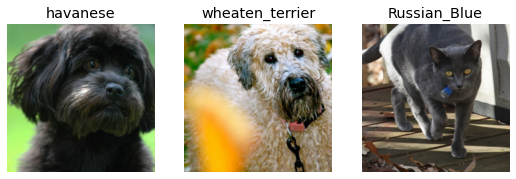

In [13]:
dls.show_batch(nrows=1,ncols=3)

## Lets Debug Augmentation
get unique = "true"


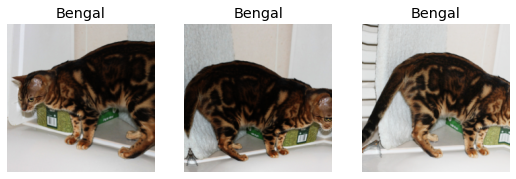

In [14]:
dls.show_batch(nrows=1,unique=True,ncols=3)

## Failure in DataBlock
Issues
1. different images different sizes
2. unable to collate them to batch


you can see everything happens

In [16]:
pets1 = DataBlock(blocks = (ImageBlock,CategoryBlock),
                 get_items= get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),"name"))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/hassan/.fastai/data/oxford-iiit-pet/images/Bengal_21.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/hassan/.fastai/data/oxford-iiit-pet/images/Bengal_21.jpg
    applying partial gives
      Bengal
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(1))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item

RuntimeError: stack expects each tensor to be equal size, but got [3, 333, 500] at entry 0 and [3, 500, 333] at entry 1

## Question

What if your image size is less than resize?

Ans: if you remember lesson we look at different ways to create this thing

**squish**

**Pad**

etc

Squish and Pad will help you

You model can teach you about problem is your data


we are getting 7 percent error



In [17]:
learn = cnn_learner(dls,resnet34, metrics= error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.550659,0.343768,0.112991,01:17


epoch,train_loss,valid_loss,error_rate,time
0,0.499403,0.284659,0.092693,00:52
1,0.322509,0.225260,0.071042,00:52


## Train Model help Clean Data

why? 

Initial model will help you clean data 

Remember we have 

**interpret.toplosses** help us identify mislables

**confusion matrix** help us where we are confused

**ImageClassifierCleaner** let us find for example two bears top confused things

Model helping you and then go ahead train data after cleaning


Notebook4 included loss function
Fastai atomatically pick good loss function

Lets look what acc. it picks

In [18]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Cross Entropy

Same as Mnist loss ..kind of extended version

torch.where only works when you have binary outcome

we want to create just like that but we want to make it work more than two categories


## Lets see whats inside Batch

destructure
batch size = 64

dls.vocab



In [20]:
x,y = dls.one_batch()

In [21]:
y

TensorCategory([18,  9, 25, 34,  3,  8,  0, 32, 34,  5, 25, 11,  6, 13,  9,  1, 24, 35,  2, 11,  8, 34,  8, 19,  4, 12, 22, 21, 33, 36,  4, 22,  2,  0, 11, 31, 11, 10, 25,  1, 16, 34,  9, 34, 28, 14, 35, 23,
         4, 30,  6, 18,  6,  3,  1,  0, 17, 29,  9,  0, 36,  1, 19, 24], device='cuda:0')

In [23]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [24]:
dls.vocab[16]

'boxer'

## View the predictions
its just call the last activation

In [25]:
preds,_ = learn.get_preds(dl= [(x,y)])
preds[0]

tensor([3.4538e-08, 4.2205e-08, 1.9436e-08, 1.4860e-09, 5.7749e-09, 1.6279e-09, 1.2292e-07, 1.6320e-08, 1.5716e-09, 2.1889e-09, 6.1163e-09, 1.2288e-08, 9.4265e-09, 1.5222e-08, 6.4298e-07, 8.6435e-08,
        2.8108e-09, 7.4216e-10, 1.0000e+00, 1.4728e-07, 2.3619e-08, 2.5580e-07, 6.9385e-08, 2.6536e-07, 1.3434e-09, 5.1199e-08, 1.4338e-07, 3.0624e-07, 2.8690e-08, 1.4353e-10, 1.6353e-08, 2.4403e-09,
        7.6845e-08, 4.8428e-09, 1.3173e-09, 1.5541e-07, 1.1432e-07])

In [26]:
len(preds[0]), preds[0].sum()

(37, tensor(1.))

## How  do we go about this prediction

Softmax is an extension of sigmoid handle more than two categoreis

what if we want 37 cat.

we need one activation for 1 category
 e.g in case 3,7 activations are two
 
 
 below 1st column is activation of 1st cat and 2nd is for 7
 
 like how much like 3 and how much like 7
 
 

In [27]:
torch.random.manual_seed(42),
acts = torch.randn((6,2))*2
acts

#How much likely is first and how muc to 7 i.e

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

## Taking Sigmoid

if we take it values will be between 0 or 1


but dont add up to one

so doesnt make sense





In [28]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

## Solution :


1. So if we take difference 

2. Relative confidence: take sigmoid after

In [29]:
diff = acts[:,0]- acts[:,1]

In [30]:
diff

tensor([ 0.4158,  0.0083, -1.8731,  5.6924,  0.3886, -0.5489])

In [31]:
torch.stack([diff.sigmoid(),1-diff.sigmoid()],dim=1)

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

## More than 2 cat:

Use Softmax

in binary case it is equal to sigmoid


The second column (the probability of it being a 7) will then just be that value subtracted from 1. Now, we need a way to do all this that also works for more than two columns. It turns out that this function, called `softmax`, is exactly that:

``` python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

> jargon: Exponential function (exp): Literally defined as `e**x`, where `e` is a special number approximately equal to 2.718. It is the inverse of the natural logarithm function. Note that `exp` is always positive, and it increases _very_ rapidly!

Let's check that `softmax` returns the same values as `sigmoid` for the first column, and those values subtracted from 1 for the second column:

In [32]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

`softmax` is the multi-category equivalent of `sigmoid`—we have to use it any time we have more than two categories and the probabilities of the categories must add to 1, and we often use it even when there are just two categories, just to make things a bit more consistent. We could create other functions that have the properties that all activations are between 0 and 1, and sum to 1; however, no other function has the same relationship to the sigmoid function, which we've seen is smooth and symmetric. Also, we'll see shortly that the softmax function works well hand-in-hand with the loss function we will look at in the next section.

If we have three output activations, such as in our bear classifier, calculating softmax for a single bear image would then look like something like <<bear_softmax>>.

<img alt="Bear softmax example" width="280" id="bear_softmax" caption="Example of softmax on the bear classifier" src="images/att_00062.png">

## Interesting thing

e to power something grows really fast
see below

if we have one activation is bit bigger than other

then softmax is really big

its tries to pick one whcih one 


thats not you always want sometimes you have inference time you want to bit concious

its default you do most of time

so that is somtmax







In [33]:
math.exp(4)

54.598150033144236

math.exp(6)

In [34]:
math.exp(6)

403.4287934927351

## Log Likelihood

binary case. we did this

```python
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()
```

its fine it worked so we could do thing exactly same thing

because tagets are not 0 or 1








In [35]:
targ = tensor([0,1,0,1,1,0])

In [38]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

## Replace torch.where

1. grab all number from 0-5
2. my targets 
3. each row number it will pick particular column defined in target
4. lets see pick column 0  for first row


so this is super nifty indexing expression you should play with

1st thing say which row you should return

second says which column

we can use that more than two values


In [39]:
idx = range(6)
sm_acts[idx,targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [46]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts , columns=["3","7"])
df["target"] = targ
df["idx"] = idx
df["loss"] = sm_acts[range(6), targ]
t= df.style.hide_index()

#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))



3,7,target,idx,loss
0.602469,0.397531,tensor(0),0,tensor(0.6025)
0.502065,0.497935,tensor(1),1,tensor(0.4979)
0.133188,0.866811,tensor(0),2,tensor(0.1332)
0.996640,0.003360,tensor(1),3,tensor(0.0034)
0.595949,0.404051,tensor(1),4,tensor(0.4041)
0.366118,0.633882,tensor(0),5,tensor(0.3661)


## How to make it Work More than 2 colums

1. full mnist : we will have more 10 columns
2. indexer



## Negative Log Liklihood

There is no log in it we will see

In [47]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [51]:
F.nll_loss(sm_acts,targ,reduction="none")

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

## Lets Talk about Logs


**Problem : That means that our model will not care whether it predicts 0.99 or 0.999. Indeed, those numbers are so close together but in another sense, 0.999 is 10 times more confident than 0.99**



The function we saw in the previous section works quite well as a loss function, but we can make it a bit better. The problem is that we are using probabilities, and probabilities cannot be smaller than 0 or greater than 1. That means that our model will not care whether it predicts 0.99 or 0.999. Indeed, those numbers are so close together—but in another sense, 0.999 is 10 times more confident than 0.99. So, we want to transform our numbers between 0 and 1 to instead be between negative infinity and infinnity. There is a mathematical function that does exactly this: the *logarithm* (available as `torch.log`). It is not defined for numbers less than 0, and looks like this:




so this log fuctoin

we can acc make it better

what if model decide 0.99 or 0.999

if we have 1000 things then right one is better than 0.99


so really we like to transform numbers between 0-1 instead -infinite to positive infinite

log will help us in this case


so 

numbers as we closer to zero its goes down to infinity at 1 it goes to zeros




In [60]:
torch.log(tensor(0.01)), torch.log(tensor(1)),torch.log(tensor(0.))

(tensor(-4.6052), tensor(0.), tensor(-inf))

we cant go zero

our loss function we want to be negative


(y = b power a)
a= log(y,b)


what intersting

log (a*b) = log(a) + log(b)

a*b can be very very big or small

adding not get out of control

when we take the probabilities such as sm_acts

1. we take log 

2. we take mean

that is called negative log likelihood


**if we take softmax 
and then log*

pass to nll_loss


which is cross Entropy Loss


why nll_loss dont take Log?


the reason it is more convinient to take log back at softmax step


so pytorch has fuction. log_softmax since it is very easir pytirch assume u did log softmax and pass to nll loss function

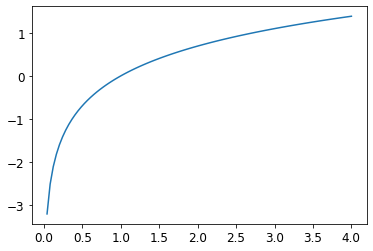

In [62]:
plot_function(torch.log, min=0,max=4)

## Two ways for Cross entropy Loss


single number because of mean

reduction = none 

for looking all

In [63]:
loss_func=nn.CrossEntropyLoss()

In [64]:
loss_func(acts,targ)

tensor(1.8045)

In [66]:
F.cross_entropy(acts,targ)

tensor(1.8045)

In [67]:
nn.CrossEntropyLoss(reduction="none")(acts,targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## why loss function needs to negative?

Lower it is better 

needed to cuttoff


next week Data Ethics:



